<a href="https://colab.research.google.com/github/ClovisDyArx/SSL/blob/main/tp2/TP_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoencoder (VAE) with Latent Space Interpolation on MNIST**

## Project Description

In this practical assignment, we explore the concepts of **Variational Autoencoders (VAEs)** by implementing and training a convolutional VAE on the MNIST dataset. The primary objectives are to learn how VAEs encode data into a structured latent space and to investigate how this latent space can be leveraged for generating new data and understanding data features.

### Key Learning Goals:
1. **Data Loading and Preprocessing**: Load the MNIST dataset and prepare it for training a convolutional neural network.
2. **VAE Architecture**: Define a VAE model with convolutional layers for encoding and decoding images, including a reparameterization trick to ensure smooth sampling from the latent space.
3. **VAE Loss Function**: Understand and implement the VAE loss, which combines reconstruction loss and KL-divergence to balance accurate reconstructions with a regularized latent space.
4. **Model Training**: Train the VAE model on MNIST, observe loss trends, and understand the impact of balancing reconstruction quality and latent space regularization.
5. **Latent Space Visualization**: Perform latent space interpolation by linearly blending between two points in the latent space, generating smooth transitions between two digit classes.

## Step 1: Loading the MNIST Dataset

In this first step, we load the MNIST dataset, which contains 28x28 grayscale images of handwritten digits (0-9). Each image represents a single digit.

We use PyTorch's `torchvision.datasets` and `DataLoader` to load and preprocess the data efficiently.

### Code Breakdown:
- **Transforms**: `transforms.Compose([transforms.ToTensor()])` converts each image into a tensor format. This allows the data to be used in PyTorch models.
- **Dataset**: `datasets.MNIST` loads the MNIST dataset and applies the specified transform. We set `download=True` to ensure the data is downloaded if it hasn't been already.
- **DataLoader**: The `DataLoader` wraps the dataset and enables batching, shuffling, and parallel loading.

This setup provides a `train_loader`, which we will use to feed batches of images into our model during training.

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Loading MNIST data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:03<00:00, 2.80MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.92MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.67MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 2: Defining the Convolutional VAE Model

In this section, we define the architecture of a **Variational Autoencoder (VAE)** with convolutional layers, designed to process the MNIST dataset.

### Code Breakdown:

1. **Initialization and Latent Dimension**:
   - `latent_dim=2` is defined as the dimensionality of the latent space. Setting it to a low number (e.g., 2) makes the latent space easy to visualize.

2. **Encoder**:
   - The encoder consists of three convolutional layers:
     - The first layer transforms the input image of size 1x28x28 to a feature map of size 32x14x14.
     - The second layer further reduces it to a size of 64x7x7.
     - The third layer compresses this to a size of 128x1x1.
   - This results in a flattened feature vector, which is then fed into two fully connected layers (`fc_mu` and `fc_logvar`) to produce the **mean** (`mu`) and **log-variance** (`logvar`) of the latent space.

3. **Reparameterization Trick**:
   - In `reparameterize`, we use the mean and log-variance vectors to sample from a Gaussian distribution. This is done by computing:

     z = \mu + \sigma \cdot \epsilon

   - Here, `epsilon` is a random noise sampled from a standard normal distribution. This allows gradients to backpropagate through the sampling process.

4. **Decoder**:
   - The decoder starts with a fully connected layer to expand the latent vector (`z`) back to a shape compatible with the convolutional layers.
   - It then passes through three transposed convolutional layers to reconstruct the original image shape:
     - The first layer reshapes it to 64x7x7.
     - The second layer outputs 32x14x14.
     - The final layer produces the original shape, 1x28x28, with pixel values normalized between 0 and 1 using a Sigmoid activation.

5. **Forward Pass**:
   - `encode`: Passes the input through the encoder to obtain `mu` and `logvar`.
   - `reparameterize`: Samples from the latent distribution using `mu` and `logvar`.
   - `decode`: Reconstructs the image from the latent vector `z`.
   - Returns the reconstructed image along with `mu` and `logvar` for further use in the loss calculation.

This architecture allows the VAE to encode images to a low-dimensional latent space and then decode them back to their original shape.

In [50]:
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(ConvVAE, self).__init__()

        # Encoder with convolutional layers
        self.encoder = nn.Sequential(
            # Input 1x28x28 -> Output 32x14x14
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Input 32x14x14 -> Output 64x7x7
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Input 64x7x7 -> Output 128x1x1
            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=1),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(1152, 128),
        )

        # Layers to produce mean and variance vectors
        # Decoder with transposed convolutional layers

        # Mean vector of the latent space
        self.fc_mu = nn.Linear(128, latent_dim)

        # Log-variance vector of the latent space
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder starting with a fully connected layer
        # Transform latent vector back to decoder shape

        # Decoder with transposed convolutional layers to reconstruct the image
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 1 * 1),
            nn.Unflatten(1, (128, 1, 1)),

            # Input 128x1x1 -> Output 64x7x7
            nn.ConvTranspose2d(128, 64, kernel_size=7, stride=1, padding=1), # FIXME: comment passer de 1x1 à 7x7 ?
            nn.ReLU(),

            # Input 64x7x7 -> Output 32x14x14
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            # Input 32x14x14 -> Output 1x28x28
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        # Normalize output pixels between 0 and 1
        # TODO: find a way to normalize the output pixels between 0 and 1



    def encode(self, x):
        # Apply the encoder to extract features and flatten the result
        # Compute mean and log-variance for the latent space distribution
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Compute standard deviation from log-variance
        # Sample epsilon from a normal distribution
        # Reparameterization trick to sample z from N(mu, sigma^2)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # Apply fully connected layer to expand latent vector to decoder's initial shape
        # Apply the decoder to reconstruct the image
        h = self.decoder(z)
        return h

    def forward(self, x):
        # Forward pass through encoder
        # Sample from latent distribution
        mu, logvar = self.encode(x)
        z = self.reparameterize(*self.encode(x))
        # Forward pass through decoder
        return self.decode(z), mu, logvar

In [51]:
from torchsummary import summary

model = ConvVAE(latent_dim=2).to(device)
print(summary(model, (1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
              ReLU-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 3, 3]         401,536
              ReLU-6            [-1, 128, 3, 3]               0
           Flatten-7                 [-1, 1152]               0
            Linear-8                  [-1, 128]         147,584
            Linear-9                    [-1, 2]             258
           Linear-10                    [-1, 2]             258
           Conv2d-11           [-1, 32, 14, 14]             320
             ReLU-12           [-1, 32, 14, 14]               0
           Conv2d-13             [-1, 64, 7, 7]          18,496
             ReLU-14             [-1, 6

## Step 3: Defining the VAE Loss Function

The Variational Autoencoder (VAE) loss function combines two key components: **Reconstruction Loss** and **KL-Divergence Loss**. Together, these terms encourage the VAE to produce high-quality reconstructions while also regularizing the latent space.

### Code Breakdown:

1. **Flattening**:
   - Both `recon_x` (the reconstructed image) and `x` (the original image) are flattened to a shape of `[batch_size, 784]` to match the expected input shape for the binary cross-entropy function.

2. **Reconstruction Loss (Binary Cross-Entropy)**:
   - We use Binary Cross-Entropy (BCE) as the reconstruction loss. This term measures the pixel-wise difference between the original and reconstructed images.
   - `BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')` sums the error over all pixels in the batch, promoting accurate reconstructions.

3. **KL-Divergence Loss**:
   - The KL-Divergence term measures the difference between the learned latent distribution `q(z|x)` and a standard normal distribution `p(z) = N(0, 1)`.
   - The calculation:
\[
     KLD = -0.5 \sum (1 + \log(\sigma^2) - \mu^2 - \sigma^2)
\]
   - This term penalizes deviations from the standard normal distribution, helping to structure the latent space and ensure continuity.

4. **Total VAE Loss**:
   - The final loss is the sum of the reconstruction loss (BCE) and the KL-Divergence loss (KLD). Minimizing this total loss encourages the model to reconstruct images accurately while keeping the latent space organized.

By using this combined loss, the VAE learns to generate images that resemble the input data and maintain a well-structured latent space that facilitates tasks like image generation and interpolation.

In [52]:

def loss_function(recon_x, x, mu, logvar):
    # Flatten the output to match the shape of x
    batch_size = x.size(0)
    x = x.view(batch_size, -1)
    recon_x = recon_x.view(batch_size, -1)

    # Also flatten x for consistency
    x = x.view(batch_size, -1)

    # Reconstruction loss: Binary Cross Entropy
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL-Divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total VAE loss
    return BCE + KLD

## Step 4: Training the VAE Model

In this step, we set up and execute the training loop for the Variational Autoencoder (VAE) model. The training process optimizes the model’s parameters to minimize the combined loss function over multiple epochs.

### Code Breakdown:

1. **Setting up the Device**:
   - The code detects if a GPU is available using `torch.cuda.is_available()`. If so, it uses the GPU for faster training; otherwise, it defaults to the CPU.

2. **Model and Optimizer Initialization**:
   - We create an instance of the `ConvVAE` model with a specified `latent_dim`. A small latent dimension (like 2) makes it easier to visualize the latent space later.
   - The model is sent to the chosen device (CPU or GPU).
   - The optimizer is set up using Adam with a learning rate of 0.001, which is well-suited for training VAEs.

3. **Training Loop**:
   - `num_epochs` defines the number of times the entire dataset is processed during training.
   - For each epoch:
     - The model is set to training mode (`model.train()`), which activates features like dropout (if used).
     - `train_loss` is initialized to accumulate the total loss over the epoch.
     - For each batch in `train_loader`:
       - **Data Transfer**: The batch of images is transferred to the chosen device.
       - **Gradient Reset**: `optimizer.zero_grad()` resets gradients from the previous batch to prevent accumulation.
       - **Forward Pass**: The data is passed through the model, which outputs `recon_batch` (reconstructed images), `mu` (mean), and `logvar` (log-variance) of the latent distribution.
       - **Loss Calculation**: `loss_function` computes the VAE loss by combining reconstruction and KL-divergence losses.
       - **Backpropagation**: `loss.backward()` computes the gradients for all model parameters.
       - **Optimization Step**: `optimizer.step()` updates the parameters using the calculated gradients.
       - The batch loss is added to `train_loss` to track the total loss for the epoch.
   
   - After each epoch, the average loss for that epoch is printed for monitoring progress. This average loss helps to assess if the model is converging.

The training loop fine-tunes the VAE’s parameters to generate accurate reconstructions and a well-structured latent space, which can be visualized or used for generative tasks after training.

In [55]:
from torch.optim import Adam


# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer, and send model to device
latent_dim = 2
model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move data to device
        data = data.to(device)

        # Zero the gradients
        optimizer.zero_grad()


        # Forward pass through the VAE
        recon_batch, mu, logvar = model(data)


        # Calculate the VAE loss
        loss = loss_function(recon_batch, data, mu, logvar)


        # Backpropagation and optimization
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    # Print the average loss for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1/10, Loss: 186.1797
Epoch 2/10, Loss: 160.5237
Epoch 3/10, Loss: 156.3280
Epoch 4/10, Loss: 153.5772
Epoch 5/10, Loss: 151.6550
Epoch 6/10, Loss: 150.1652
Epoch 7/10, Loss: 149.0226
Epoch 8/10, Loss: 148.1040
Epoch 9/10, Loss: 147.3816
Epoch 10/10, Loss: 146.7756


## Step 5: Interpolation in the Latent Space

In this final step, we perform **latent space interpolation** to explore the continuity of the VAE's learned latent space. By interpolating between two points in the latent space (representing different digits), we can generate a smooth transition between them.

### Code Breakdown:

1. **Defining the Interpolation Function**:
   - `interpolate_and_generate`: This function takes two latent vectors (`z_start` and `z_end`) and generates intermediate points between them.
   - **Interpolation**: We create a series of interpolated points by linearly blending `z_start` and `z_end` with interpolation weights `t` ranging from 0 to 1.
   - **Decoding**: Each interpolated vector is decoded by the VAE’s decoder to produce an image, which is stored in the `images` list.

2. **Selecting Points to Interpolate**:
   - We randomly select two samples from the dataset (e.g., images of "1" and "7").
   - These images are passed through the encoder to obtain their latent representations, `z_start` and `z_end`.

3. **Generating and Visualizing the Interpolation**:
   - The interpolated latent points are decoded back into images.
   - We then plot each decoded image side-by-side to visualize the transformation from the starting digit to the ending digit.
   
   Each intermediate image represents a gradual change in the latent space between `z_start` and `z_end`, showing how the model "morphs" one digit into another.

### Visualization Explanation:

The visualization showcases the VAE’s ability to generate new images by sampling from the latent space. The smooth transition between digits demonstrates that the VAE has learned a well-structured, continuous latent space where similar concepts (like digits) are located close to each other. This capability can be useful for generating synthetic data or exploring variations in features.

By interpolating in this manner, we can observe how the VAE understands and generates the fundamental features of the digits in the MNIST dataset.

In [ ]:
# Plot the interpolated images
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(interpolated_images[i][0, 0], cmap='gray')
    ax.axis('off')

plt.show()

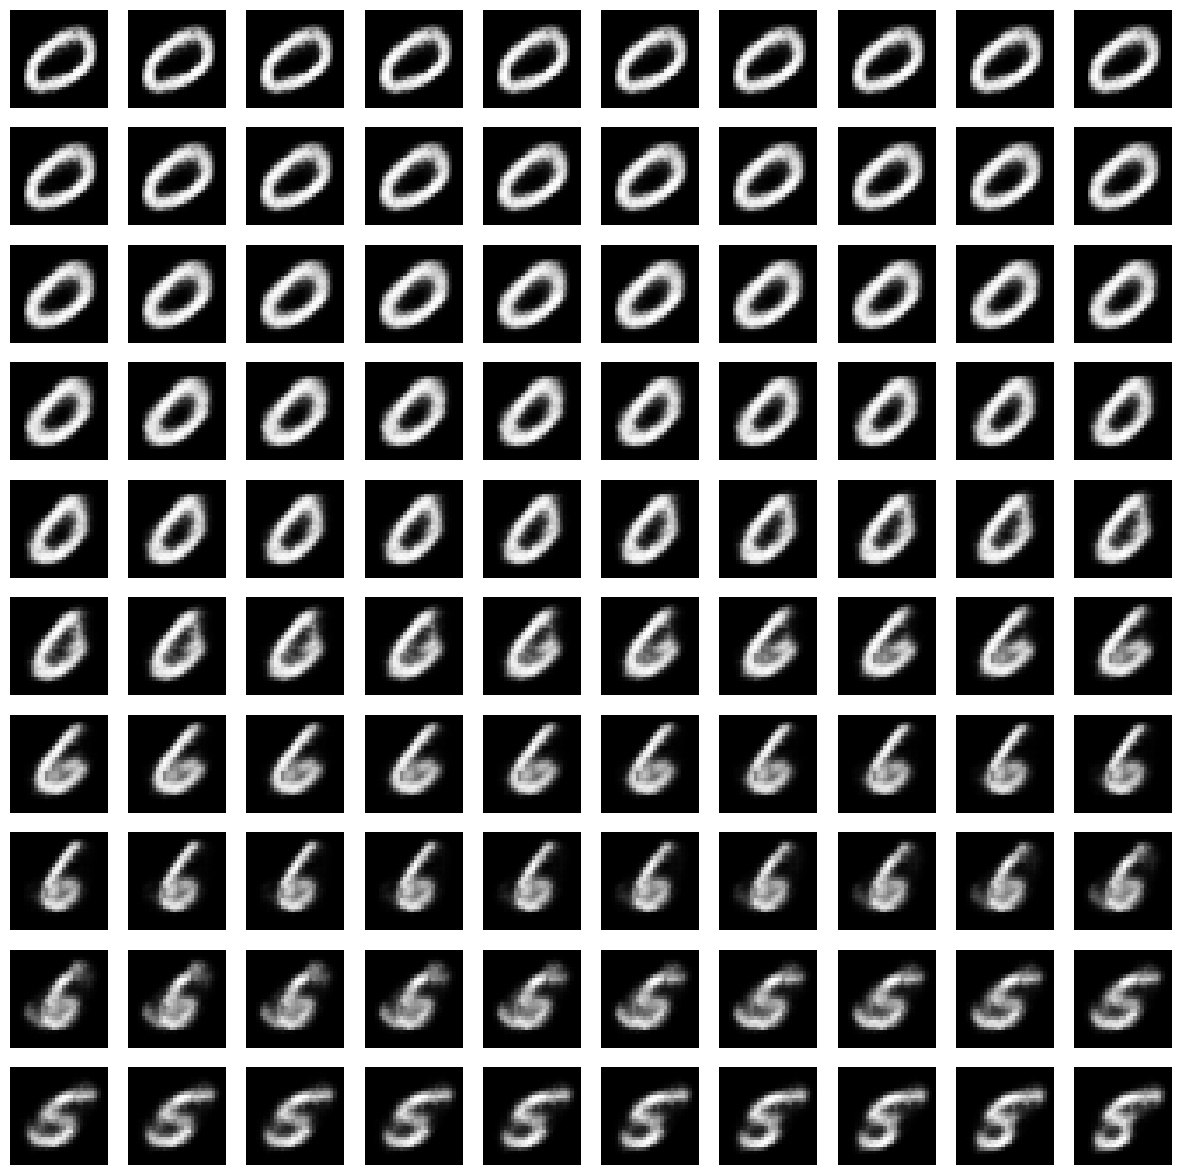

In [64]:
import matplotlib.pyplot as plt
import numpy as np


# Define the interpolation function
def interpolate_and_generate(model, z_start, z_end, steps=10):
    # Create interpolation steps between two latent vectors
    # Decode each interpolated point and store the images
    images = []
    for t in np.linspace(0, 1, steps):
        z = (1 - t) * z_start + t * z_end
        image = model.decode(z.to(device))
        images.append(image.detach().cpu().numpy())
    return images

# Select two random digits to interpolate between
model.eval()
with torch.no_grad():
    # Pass the data directly without reshaping, as the model expects [1, 1, 28, 28]
    # Randomly select two samples from the dataset for interpolation
    num_samples = 2
    steps = 100
    random_indices = np.random.choice(len(train_dataset), num_samples, replace=False)
    sample1, _ = train_dataset[random_indices[0]]
    sample2, _ = train_dataset[random_indices[1]]

    # Encode the samples into the latent space
    z_start, _ = model.encode(sample1.unsqueeze(0).to(device))
    z_end, _ = model.encode(sample2.unsqueeze(0).to(device))

    # Generate the interpolation sequence
    interpolated_images = interpolate_and_generate(model, z_start, z_end, steps=steps)

# Plot the interpolated images
# Create a figure and subplots with 10 rows and 10 columns
fig, axes = plt.subplots(10, 10, figsize=(15, 15)) # Change figsize for better visualization

# Iterate through the interpolated images and display them in the subplots
for i in range(10):  # Iterate through rows
    for j in range(10):  # Iterate through columns
        image_index = i * 10 + j  # Calculate the index of the image to display
        axes[i, j].imshow(interpolated_images[image_index][0, 0], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels

plt.show()